# Convolutional Neural Networks (CNNs) with PyTorch

In this notebook, we explore the workings of Convolutional Neural Networks (CNNs) using PyTorch. CNNs are a type of neural network specifically designed for processing grid-like data, such as images.

We will:
- **Implement a simple CNN using PyTorch to understand the underlying operations.**
- Build a CNN from scratch using PyTorch.
- Understand the components of CNNs, including convolutional layers, pooling layers, and activation functions.
- Visualize feature maps to gain insight into the network's operation.
- **Visualize what the neural network is learning at each layer to understand patterns like vertical, horizontal, and diagonal edges.**

## Implementing a Simple CNN with PyTorch

To grasp the fundamental operations of a CNN, we'll start by implementing a simple convolution and pooling operation using PyTorch tensors. This example mirrors the Numpy implementation but leverages PyTorch for better integration with our later models.

### Simple Convolution and Pooling

We will create a 6x6 grayscale image and a 3x3 filter (kernel). We'll perform a convolution operation followed by max pooling.

In [11]:
import torch
import torch.nn.functional as F

# Define the 6x6 grayscale image
image = torch.tensor([[1, 1, 1, 0, 0, 0],
                      [0, 1, 1, 1, 0, 0],
                      [0, 0, 1, 1, 1, 0],
                      [0, 0, 1, 1, 0, 0],
                      [0, 1, 1, 0, 0, 1],
                      [1, 1, 0, 0, 1, 1]], dtype=torch.float32)

# Reshape the image to match PyTorch's expected input shape: (N, C, H, W)
image = image.unsqueeze(0).unsqueeze(0)

# Define the 3x3 filter
kernel = torch.tensor([[1, 0, 1],
                       [0, 1, 0],
                       [1, 0, 1]], dtype=torch.float32)

# Reshape the kernel to match PyTorch's expected shape: (out_channels, in_channels, H, W)
kernel = kernel.unsqueeze(0).unsqueeze(0)

# Perform the convolution operation
convolved_image = F.conv2d(image, kernel, stride=1)

print('Convolved Image:')
print(convolved_image.squeeze())

# Perform the max pooling operation
pooled_image = F.max_pool2d(convolved_image, kernel_size=2, stride=2)

print('\nPooled Image:')
print(pooled_image.squeeze())

Convolved Image:
tensor([[4., 3., 4., 1.],
        [2., 4., 3., 3.],
        [2., 3., 4., 2.],
        [3., 3., 2., 2.]])

Pooled Image:
tensor([[4., 4.],
        [3., 4.]])


**Explanation:**

In PyTorch, the standard input shape for image data in convolutional neural networks (CNNs) is given as **(N, C, H, W)**. Here, **'N'** represents the batch size, which is the number of images processed simultaneously during training or inference. **'C'** stands for the number of channels in the image; for example, 3 for RGB images and 1 for grayscale images. **'H'** and **'W'** denote the height and width of the images, respectively, in pixels.

This format ensures that the data is properly organized for convolutional layers, which expect a specific input shape to perform operations across the spatial dimensions (height and width) and channels. By maintaining this structure, PyTorch can efficiently utilize batch processing and vectorized operations, leading to optimized computational performance during model training and evaluation.

When defining convolutional layers in PyTorch using `nn.Conv2d`, the weight tensor (filter/kernel) has the shape **(out_channels, in_channels, H, W)**. **'out_channels'** represents the number of filters in the convolutional layer, which determines the number of output feature maps produced by the convolution. **'in_channels'** corresponds to the number of input channels; for example, an RGB image has 3 input channels.

**'H'** and **'W'** denote the height and width of the convolutional kernel (filter size). The convolution operation applies these filters across the input data to extract features. Each filter learns to detect specific patterns or features in the input, and the number of output channels (filters) controls the depth of the output feature maps.

The parameter `stride=1` in convolutional or pooling layers specifies the step size with which the filter/kernel moves across the input data. A stride of 1 means that the filter shifts by one pixel at a time along the height and width dimensions. This results in the maximum possible overlap between receptive fields, leading to an output feature map that closely reflects the spatial dimensions of the input (minus any effects from padding and kernel size).

Using a stride of 1 is common when you want to preserve as much spatial information as possible from the input data. It allows the network to learn fine-grained features since every pixel in the input contributes to the output feature maps.

In contrast, setting `stride=2` in convolutional or pooling layers indicates that the filter/kernel moves two pixels at a time across the input data along the height and width dimensions. This effectively reduces the spatial dimensions of the output feature map compared to the input. In other words, the output will be downsampled by a factor equal to the stride.

Using a stride greater than 1 is a way to reduce the computational complexity and the number of parameters in the network. It helps in creating a hierarchy of features by focusing on larger patterns and reducing the resolution of the feature maps, which can be beneficial for capturing more abstract representations in deeper layers of the network.

## What are CNNs?

Convolutional Neural Networks are designed to automatically and adaptively learn spatial hierarchies of features from input data. They are commonly used for image and video recognition, recommendation systems, and natural language processing.

### Key Components of CNNs:

1. **Convolutional Layers**: Extract features from input data using convolution operations. These layers learn filters that activate when they detect specific features such as edges, textures, or patterns in the input.
   - *Additional Insight*: Convolutional layers preserve the spatial relationships between pixels by learning image features using small squares of input data.
   
2. **Pooling Layers**: Reduce spatial dimensions to make the model computationally efficient. Pooling helps in extracting dominant features which are rotational and positional invariant, thus maintaining the process of effectively training of the model.
   - *Additional Insight*: Pooling layers downsample each feature map independently, reducing the number of parameters and computation in the network.
   
3. **Activation Functions**: Add non-linearity to the network, enabling it to learn complex patterns. Common activation functions include ReLU, Sigmoid, and Tanh.
   - *Additional Insight*: Activation functions introduce non-linear properties to the network, which allows it to learn non-linear and complex mappings from inputs to outputs.
   
4. **Fully Connected Layers**: Connect all neurons to make predictions based on extracted features. They are usually the last layers in the network, transforming the learned features into the final output.
   - *Additional Insight*: Fully connected layers combine all the features learned by previous layers across the image to identify larger patterns.

In [12]:
!pip install skorch


In [13]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV

# This code sets up libraries for working with CNNs, datasets, and visualization.

## Dataset Preparation

We use the CIFAR-10 dataset, a widely-used dataset of 60,000 32x32 color images in 10 classes. The dataset is divided into 50,000 training images and 10,000 test images.

### Additional Insight:

- **CIFAR-10 Classes**: The dataset includes airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.
- **Data Normalization**: Normalizing data helps in faster convergence during training.

In [14]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the Fashion-MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Explanation:
# - `transforms.ToTensor()` converts images to PyTorch tensors.
# - `transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))` scales pixel values to have a mean of 0 and standard deviation of 1.
#   - Each parameter in `Normalize` corresponds to the mean and standard deviation for each channel (R, G, B).
#   - Changing these values affects the scaling of the data. For instance, using `(0, 0, 0), (1, 1, 1)` would leave the data unchanged after `ToTensor()`.
# - DataLoader creates batches for efficient training.

**Detailed Explanation of Normalization:**

The `transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))` function normalizes the image tensor by subtracting the mean and dividing by the standard deviation for each channel. The first tuple `(0.5, 0.5, 0.5)` represents the mean for the Red, Green, and Blue channels, respectively, and the second tuple represents the standard deviation for each channel.

By using mean and standard deviation of 0.5, the pixel values, which are initially in the range [0, 1] after `ToTensor()`, are transformed to the range [-1, 1]. This is because `(pixel - 0.5) / 0.5 = 2 * (pixel - 0.5)`, centering the data around zero. If we set the mean to 0 and the standard deviation to 1, i.e., `Normalize((0, 0, 0), (1, 1, 1))`, the data remains unchanged after `ToTensor()`. Proper normalization is crucial for effective training, as it ensures that all input features are on a similar scale, which can lead to faster convergence and improved performance.

## Visualize Dataset

Before training, let's visualize some images from the dataset to understand the data better.

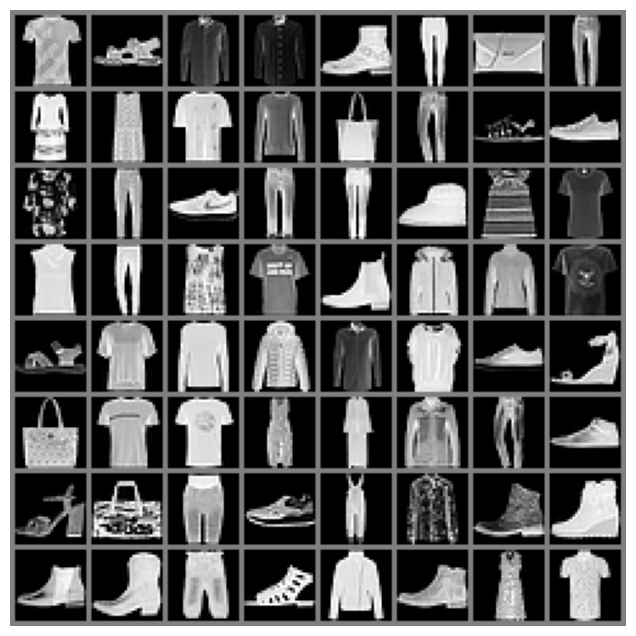

In [15]:
# Helper function to display images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(npimg[0], cmap='gray')
    plt.axis('off')
    plt.show()

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))


**Detailed Explanation:**

The line `img = img / 2 + 0.5` is used to **unnormalize** the image data for visualization purposes. During preprocessing, the images were normalized using a mean and standard deviation of 0.5, which scaled the pixel values to the range [-1, 1]. To display the images correctly, we need to transform the pixel values back to the range [0, 1]. Dividing by 2 and adding 0.5 effectively reverses the normalization process.

The line `plt.imshow(np.transpose(npimg, (1, 2, 0)))` rearranges the dimensions of the NumPy image array for proper display. PyTorch tensors have the shape (C, H, W), but `matplotlib` expects images in the shape (H, W, C). The `np.transpose` function swaps the axes so that the color channels are in the last dimension, ensuring that the image is displayed correctly with the appropriate colors.

## Define the CNN Model

The CNN includes:
- Two convolutional layers for feature extraction.
- Max pooling for dimensionality reduction.
- Fully connected layers for classification.

### Additional Insight:

- **Layer Details**:
  - `conv1`: Learns 32 filters of size 3x3.
  - `conv2`: Learns 64 filters of size 3x3.
  - **Activation Functions**: We use ReLU to introduce non-linearity.
  - **Flattening**: The output of the convolutional layers is flattened before entering the fully connected layers.
  - **Dropout (Improvement)**: We add dropout layers to prevent overfitting.

In [16]:
class CNN(nn.Module):
    def __init__(self, dropout=0.3):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)   # 1 channel
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)   # 28->14->7
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))   # (B,32,14,14)
        x = self.pool(torch.relu(self.conv2(x)))   # (B,64,7,7)
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Explanation:
# - `x = x.view(-1, 64 * 8 * 8)` reshapes the tensor to prepare for the fully connected layer.
#   - The `-1` infers the batch size.
#   - This flattens the feature maps into a vector.
# - `nn.Conv2d` defines a convolutional layer with specified input/output channels.
# - `nn.MaxPool2d` reduces the spatial dimensions of the feature maps.
# - Fully connected layers (`nn.Linear`) connect extracted features to class probabilities.
# - `nn.Dropout` helps prevent overfitting by randomly zeroing some of the elements.

# Conv1 (First Convolutional Layer)
conv1_output_channels = 32  # Number of output channels
conv1_input_channels = 3    # Number of input channels (RGB image)
conv1_kernel_size = 3       # Kernel size is 3x3
conv1_biases = conv1_output_channels  # One bias per output channel

# Formula: (Output Channels x Input Channels x Kernel Height x Kernel Width) + Biases
conv1_weights = conv1_output_channels * conv1_input_channels * conv1_kernel_size * conv1_kernel_size
conv1_total_weights = conv1_weights + conv1_biases  # Total weights for Conv1

# Conv2 (Second Convolutional Layer)
conv2_output_channels = 64  # Number of output channels
conv2_input_channels = 32   # Number of input channels (from Conv1 output)
conv2_kernel_size = 3       # Kernel size is 3x3
conv2_biases = conv2_output_channels  # One bias per output channel

# Formula: (Output Channels x Input Channels x Kernel Height x Kernel Width) + Biases
conv2_weights = conv2_output_channels * conv2_input_channels * conv2_kernel_size * conv2_kernel_size
conv2_total_weights = conv2_weights + conv2_biases  # Total weights for Conv2

# FC1 (First Fully Connected Layer)
fc1_input_neurons = 64 * 8 * 8  # Input neurons (from Conv2 output size)
fc1_output_neurons = 512        # Number of output neurons
fc1_biases = fc1_output_neurons # One bias per output neuron

# Formula: (Output Neurons x Input Neurons) + Biases
fc1_weights = fc1_output_neurons * fc1_input_neurons
fc1_total_weights = fc1_weights + fc1_biases  # Total weights for FC1

# FC2 (Second Fully Connected Layer)
fc2_input_neurons = 512   # Input neurons (from FC1 output)
fc2_output_neurons = 10   # Number of output neurons (number of classes)
fc2_biases = fc2_output_neurons  # One bias per output neuron

# Formula: (Output Neurons x Input Neurons) + Biases
fc2_weights = fc2_output_neurons * fc2_input_neurons
fc2_total_weights = fc2_weights + fc2_biases  # Total weights for FC2

# Total Weights for the Entire Network
total_weights = conv1_total_weights + conv2_total_weights + fc1_total_weights + fc2_total_weights

# Results
weights = {
    "Conv1 Weights": conv1_total_weights,
    "Conv2 Weights": conv2_total_weights,
    "FC1 Weights": fc1_total_weights,
    "FC2 Weights": fc2_total_weights,
    "Total Weights": total_weights
}
print(f"Weights: {weights}")



Weights: {'Conv1 Weights': 896, 'Conv2 Weights': 18496, 'FC1 Weights': 2097664, 'FC2 Weights': 5130, 'Total Weights': 2122186}


**Calculating the Number of Weights:**

To calculate the number of weights in a convolutional layer, you need to consider the size of the filters (kernels), the number of input channels, and the number of output channels. The formula for the number of weights in a convolutional layer is:

**Number of weights = (kernel_height * kernel_width * in_channels * out_channels) + out_channels**

The additional `out_channels` accounts for the bias term for each filter. For example, in the first convolutional layer `conv1`, we have 32 filters (`out_channels=32`), each of size 3x3 (`kernel_size=3`), and the input has 3 channels (`in_channels=3`). The number of weights is:

Number of weights = (3 * 3 * 3 * 32) + 32 = (27 * 32) + 32 = 864 + 32 = **896**


Calculating the number of weights helps in understanding the model's capacity and computational requirements.

## Visualizing Filters and Feature Maps

Understanding what the network learns at each layer helps demystify the "black box" nature of deep learning models.

### Visualizing Filters

In [ ]:
def visualize_filters(layer):
    filters = layer.weight.data.clone()

    filters = filters - filters.min()
    filters = filters / filters.max()
    filter_num = filters.shape[0]
    n_columns = 8
    n_rows = filter_num // n_columns + (filter_num % n_columns > 0)

    fig, axs = plt.subplots(n_rows, n_columns, figsize=(n_columns, n_rows))

    for i in range(filter_num):
        row = i // n_columns
        col = i % n_columns
        axs[row, col].imshow(filters[i][0], cmap='gray')  # single channel
        axs[row, col].axis('off')

    plt.show()

model = CNN()
visualize_filters(model.conv1)


**Detailed Explanation:**

The `visualize_filters` function is designed to display the filters (kernels) learned by a convolutional layer in a neural network. The function takes a layer as input and accesses its weight data. It normalizes the weights to a 0-1 range by subtracting the minimum value and dividing by the maximum value, which is necessary for visual representation.

It then calculates the number of filters and organizes them into a grid for display using `matplotlib`. The filters are permuted to change their shape from `(channels, height, width)` to `(height, width, channels)` for proper visualization. The function iterates over each filter, placing them in the grid, and turns off the axis for clarity. Finally, it displays the filters, allowing us to inspect what features the network has learned to detect.

### Visualizing Feature Maps

In [ ]:
def visualize_feature_maps(image, model):
    model.eval()
    device = next(model.parameters()).device
    with torch.no_grad():
        x = image.unsqueeze(0).to(device)  
        x = torch.relu(model.conv1(x))      
        feature_maps = x.squeeze(0).cpu()   

    num_maps = feature_maps.shape[0]
    n_columns = 8
    n_rows = num_maps // n_columns + (num_maps % n_columns > 0)

    fig, axs = plt.subplots(n_rows, n_columns, figsize=(15, 8))
    for i in range(num_maps):
        row = i // n_columns
        col = i % n_columns
        axs[row, col].imshow(feature_maps[i].numpy(), cmap='gray')
        axs[row, col].axis('off')

    for j in range(num_maps, n_rows * n_columns):
        axs[j // n_columns, j % n_columns].axis('off')

    plt.show()

sample_image, _ = train_dataset[0]
visualize_feature_maps(sample_image, model)


**Explanation:**
- **Filters**: Visualize the learned weights of convolutional layers.
- **Feature Maps**: Show the activation maps after applying the filters to an input image.
- The `x.detach()` function creates a tensor that is detached from the computation graph, which is necessary when we want to visualize the activations without tracking gradients.

Explanation:

• Filters:
The convolutional filters represent the learned weights of the convolutional layers.
In the first convolutional layer, these filters typically learn low-level visual
features such as edges, corners, and simple texture patterns.

• Feature Maps:
Feature maps are the activation outputs produced after applying the convolutional
filters to an input image followed by a non-linear activation function (ReLU).
Each feature map highlights regions in the image where a specific filter responds
strongly.

• Detaching from the computation graph:
The x.detach() operation creates a tensor that is disconnected from the computation
graph. This is required when visualizing filters or feature maps, as we do not need
to compute gradients during visualization, which saves memory and computation.


## Training the Model

We define a training loop to update model weights using backpropagation.

### Improvements Made:

- **Learning Rate Adjustment**: We use a scheduler to reduce the learning rate if the validation loss plateaus.
- **Data Augmentation**: Added random horizontal flips to increase dataset variability.
- **Increased Epochs**: Training for more epochs to improve accuracy.

In [ ]:
# Updated transformations with data augmentation (Fashion-MNIST)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(28, padding=4),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_train)
test_dataset  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 12
train_losses = []
val_losses = []

for epoch in range(num_epochs):  
    running_loss = 0.0
    model.train()

    for inputs, labels in train_loader:
        optimizer.zero_grad()          
        outputs = model(inputs)     
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()             
        running_loss += loss.item()

    # Validation phase
    if epoch % 2 == 0:
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss = val_loss / len(test_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Plotting training and validation loss
plt.figure(figsize=(10,5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Validation checkpoints (every 2 epochs)')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Explanation:
# - `model.train()` sets the model to training mode, enabling behaviors like dropout and batch normalization.
# - Added a learning rate scheduler to adjust learning rate during training.
# - Implemented data augmentation to improve generalization.

**Detailed Explanation of `model.train()`:**

The `model.train()` method in PyTorch sets the model to training mode. This is important because certain layers, such as Dropout and BatchNorm, behave differently during training and evaluation. In training mode, Dropout layers randomly zero out some of the elements of the input tensor with a specified probability to prevent overfitting. BatchNorm layers compute and use batch statistics (mean and variance) to normalize the data.

By invoking `model.train()`, you ensure that these layers operate in their training configuration, which is essential during the training loop. Before evaluation or testing, you should set the model to evaluation mode using `model.eval()` to switch off certain behaviors like Dropout and to use running estimates in BatchNorm layers instead of batch statistics.

## Testing the Model

Evaluate the model's performance on unseen data.

In [ ]:
# Test the model
correct = 0
total = 0
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():  
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


## Confusion Matrix

To gain deeper insights into the model's performance, let's plot a confusion matrix.

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Understanding Learned Features

### Visualizing Weights After Training

In [ ]:
# Visualize the filters of the first convolutional layer after training
visualize_filters(model.conv1)

### Feature Maps at Different Layers

We can visualize how the input image is transformed as it passes through different layers.

In [ ]:
# --- Prepare a subset for faster grid search ---
subset_size = 6000
X = np.stack([train_dataset[i][0].numpy() for i in range(subset_size)])  # (N,1,28,28)
y = np.array([train_dataset[i][1] for i in range(subset_size)])          # (N,)

net = NeuralNetClassifier(
    CNN,
    max_epochs=5,   # base value, grid will override
    lr=0.01,        # base value, grid will override
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss,
    batch_size=64,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

params = {
    'lr': [0.01, 0.001],
    'max_epochs': [5, 10],
    'module__dropout': [0.3, 0.5],
    'optimizer': [optim.Adam, optim.SGD],
    'optimizer__weight_decay': [0.0, 1e-4],
}

gs = GridSearchCV(net, params, refit=True, cv=3, scoring='accuracy')
gs.fit(X, y)

print('Best score:', gs.best_score_)
print('Best params:', gs.best_params_)
best_net = gs.best_estimator_

# --- Evaluate on test set ---
X_test = np.stack([test_dataset[i][0].numpy() for i in range(len(test_dataset))])  # (N,1,28,28)
y_test = np.array([test_dataset[i][1] for i in range(len(test_dataset))])

test_acc = best_net.score(X_test, y_test)
print('Test Accuracy:', test_acc)


**Explanation:**
- **First Convolutional Layer**: Detects basic features like edges and textures.
- **Second Convolutional Layer**: Builds upon the first layer to detect more complex patterns.
- The `x.detach()` function creates a tensor that is detached from the computation graph, which is necessary when we want to visualize the activations without tracking gradients.

## Hyperparameter Tuning with GridSearchCV

To fine-tune the hyperparameters of our CNN model, we can use `GridSearchCV` from `scikit-learn`. However, since `GridSearchCV` doesn't directly support PyTorch models, we'll use the `skorch` library, which provides a scikit-learn compatible wrapper for PyTorch models.

In [ ]:
# Install skorch if not already installed
!pip install skorch

from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV

# Define the skorch neural net classifier
net = NeuralNetClassifier(
    CNN,
    max_epochs=10,
    lr=0.01,
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss,
    batch_size=64,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Prepare the data
X = [data[0].numpy() for data in train_dataset]
y = [data[1] for data in train_dataset]

# Define the parameter grid
params = {
    'lr': [0.01, 0.001],
    'max_epochs': [5, 10],
    'module__dropout': [0.3, 0.5],
    'optimizer': [optim.Adam, optim.SGD],
    'optimizer__weight_decay': [0, 0.0001]
}

# Perform Grid Search
gs = GridSearchCV(net, params, refit=True, cv=3, scoring='accuracy')

import numpy as np
X = np.array(X)
y = np.array(y)

gs.fit(X, y)

# Print the best score and parameters
print('Best score:', gs.best_score_)
print('Best params:', gs.best_params_)

# Use the best model
best_net = gs.best_estimator_

# Test the best model on test data
X_test = [data[0].numpy() for data in test_dataset]
y_test = [data[1] for data in test_dataset]
X_test = np.array(X_test)
y_test = np.array(y_test)

test_acc = best_net.score(X_test, y_test)
print('Test Accuracy:', test_acc)

**Explanation:**
- We use `skorch.NeuralNetClassifier` to wrap our PyTorch model.
- Define a parameter grid with hyperparameters to tune.
- Use `GridSearchCV` to find the best combination of hyperparameters.
- Evaluate the best model on the test dataset.

## Data Augmentation with RandomHorizontalFlip

The `transforms.RandomHorizontalFlip()` applies a horizontal flip to the input image with a default probability of 0.5. This means that, on average, half of the images will be flipped horizontally during training. This operation is a form of data augmentation, which increases the diversity of the training data without actually adding new records.

However, it does not add additional records to the dataset; instead, it transforms the existing images on-the-fly during training. Each epoch may see different augmented versions of the images due to the random nature of the transformation. This helps the model generalize better by learning invariant features to such transformations.